# Heuristics Visualization
This notebook is a demonstration of how the elbow finding heuristics will work on different datasets.
It is intended for experimentation and to determine if any adjustments should be made to handle cases such as an S-curve along the expected linear descent line.

In [1]:
import numpy as np
import sklearn.metrics
from top2vec.elbow_finding import find_elbow_index, get_distances_from_line

%matplotlib inline
import matplotlib.pyplot as plt


def plot_heuristic(
    values,
    figure_num="1",
    derivatives="distance",
    figsize=(8, 3),
    first_elbow=True,
    elbow_metric="euclidean",
):
    sorted_vals = -np.sort(-np.array(values))
    x = np.arange(sorted_vals.size)

    m = (sorted_vals[-1] - sorted_vals[0]) / (sorted_vals.size - 1)
    line = x * m + sorted_vals[0]
    # Uniform is an absolute value and therefore useless for detecting an inflection
    y_distances = get_distances_from_line(
        sorted_vals, m, sorted_vals[0], metric="raw-y", first_elbow=False
    )
    elbow = find_elbow_index(sorted_vals, first_elbow=first_elbow, metric=elbow_metric)
    if not derivatives:
        distances = []
        with_derivatives = False
    elif derivatives == "distance":
        distances = get_distances_from_line(
            sorted_vals, m, sorted_vals[0], first_elbow=False, metric=elbow_metric
        )
        with_derivatives = True
    elif derivatives == "values":
        distances = sorted_vals
        with_derivatives = True
    else:
        raise ValueError("Unknown derivatives requested.")

    plot_figure(
        sorted_vals,
        distances,
        elbow,
        line,
        figure_num=figure_num,
        with_derivatives=with_derivatives,
        y_distances=y_distances,
        figsize=figsize,
    )


def plot_figure(
    sorted_vals,
    distances,
    elbow,
    line,
    figure_num="1",
    with_derivatives=True,
    y_distances=None,
    figsize=(8, 3),
):

    distances_prime = [
        0,
    ]
    for x, distance in enumerate(distances):
        if x == 0:
            continue
        else:
            distances_prime.append(distance - distances[x - 1])
    distances_prime_prime = [0, 0]
    for x, distance_prime in enumerate(distances_prime):
        if x == 0:
            continue
        else:
            distances_prime_prime.append(distance_prime - distances_prime[x - 1])

    if not with_derivatives:
        fig = plt.figure(num=figure_num, clear=True, figsize=figsize)
        gs = fig.add_gridspec(nrows=3, ncols=1)
        if y_distances is not None:
            ax = fig.add_subplot(gs[:2, 0])
            ax_y = fig.add_subplot(gs[2, 0], sharex=ax)
            ax_y.axhline(0, color="black")
            ax_y.plot(y_distances)
            ax_y.scatter([elbow], [y_distances[elbow]])
        else:
            ax = fig.add_subplot(gs[:, 0])

    else:
        fig = plt.figure(num=figure_num, clear=True, figsize=figsize)
        if y_distances is not None:
            gs = fig.add_gridspec(nrows=3, ncols=3)
            ax = fig.add_subplot(gs[:2, 0])
            ax_y = fig.add_subplot(gs[2, 0])
            ax_y.axhline(0, color="black")
            ax_y.plot(y_distances)
            ax_y.scatter([elbow], [y_distances[elbow]])
        else:
            ax = fig.add_subplot(gs[:, 0])
        ax_d = fig.add_subplot(gs[0, 1])
        ax_d.plot(distances)
        ax_d.axhline(0, color="black")
        ax_d.xaxis.set_ticklabels([])
        ax_d_prime = fig.add_subplot(gs[1, 1], sharex=ax_d)
        ax_d_prime.plot(distances_prime)
        ax_d_prime.axhline(0, color="black")
        ax_d_prime_prime = fig.add_subplot(gs[2, 1])
        ax_d_prime_prime.plot(distances_prime_prime)
        ax_d_prime_prime.axhline(0, color="black")
        
        # Now it is the time for our differences and percent differences
        differences = sorted_vals[:-1] - sorted_vals[1:]
        average_difference = np.average(differences)
        deviation_from_average = differences - average_difference
        percent_deviation_from_average = deviation_from_average / average_difference
        ax_diffs = fig.add_subplot(gs[0, 2])
        ax_diffs.plot(differences)
        ax_avg_diffs = fig.add_subplot(gs[1, 2], sharex=ax_diffs)
        ax_avg_diffs.plot(deviation_from_average)
        ax_percent_avg_diffs = fig.add_subplot(gs[2, 2], sharex=ax_diffs)
        ax_percent_avg_diffs.plot(percent_deviation_from_average)


    # Now the stuff for everyone
    ax.plot(line)
    ax.scatter([elbow], [sorted_vals[elbow]])
    ax.plot(sorted_vals)

## Manufactured Data

In [2]:
vector = np.array([[2, 1]])
base = np.array(
    [
        [0, 1],
        [2, 1],
        [1, 0.5],
        [1, 0],
        [-1, 2],
    ]
)
opposite = np.array(
    [
        [-2, -0.8],
        [-2, -0.9],
        [-2, -0.95],
        [-2, -1],
        [-2, -1.05],
        [-2, -1.1],
        [-2, -1.2],
        [-2, -1.5],
    ]
)

test_embedding = np.vstack(
    [
        np.array(
            [
                [4, 2],
                [8, 4],
                [1, -1],
            ]
        ),
        base,
    ]
)

test_embedding_multiple_elbows = np.vstack([test_embedding, opposite])

# A different divergent case where the S-curve goes the other way
test_embedding_multiple_elbows_2 = np.vstack(
    [base, opposite, np.full((10, 2), [1, -1])]
)

sims = 1 - sklearn.metrics.pairwise_distances(vector, test_embedding, metric="cosine")
sims_multiple_elbows = 1 - sklearn.metrics.pairwise_distances(
    vector, test_embedding_multiple_elbows, metric="cosine"
)
sims_multiple_elbows_2 = 1 - sklearn.metrics.pairwise_distances(
    vector, test_embedding_multiple_elbows_2, metric="cosine"
)

## Show heuristic performance on simple embedding - one elbow

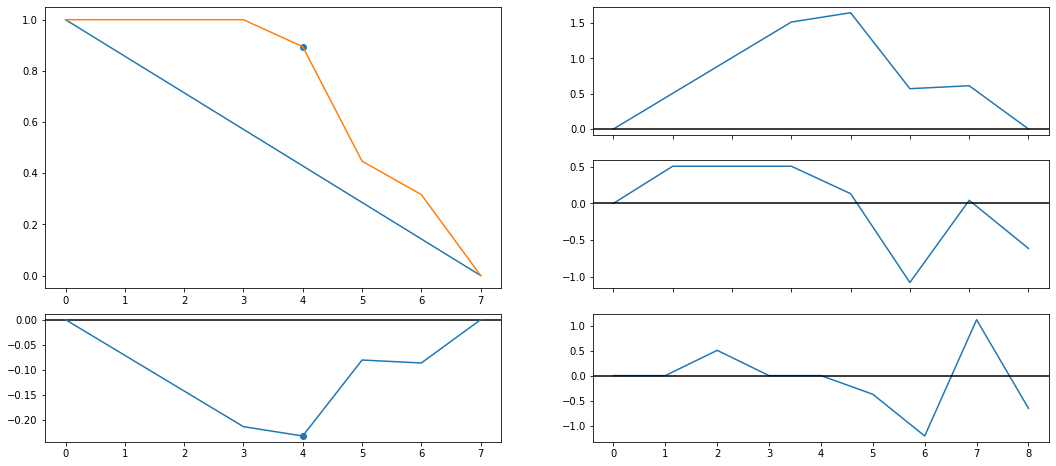

In [3]:
# The current elbow-finding heuristic also showing changes in distance from the line
plot_heuristic(
    sims[0],
    figure_num="Basic - Distance",
    derivatives="distance",
    figsize=(18, 8),
    first_elbow=False,
)

In [ ]:
# What if we wanted to use a derivative of the raw values as a cutoff?
plot_heuristic(
    sims[0],
    figure_num="Basic - Values",
    derivatives="values",
    figsize=(18, 8),
    first_elbow=False,
)

In [ ]:
# Just the elbow finding
plot_heuristic(
    sims[0],
    figure_num="Basics - No Derivatives",
    derivatives=None,
    figsize=(18, 5),
    first_elbow=False,
)

## Showing heuristic performance with multiple elbows in graph

In [ ]:
# The current elbow-finding heuristic also showing changes in distance from the line
plot_heuristic(
    sims_multiple_elbows[0],
    figure_num="2 Elbows - Distance",
    derivatives="distance",
    figsize=(18, 8),
    first_elbow=False,
)
plot_heuristic(
    sims_multiple_elbows[0],
    figure_num="2 Elbows - Distance - One Elbow",
    derivatives="distance",
    figsize=(18, 8),
    first_elbow=True,
)

In [ ]:
# What if we wanted to use a derivative of the raw values as a cutoff?
plot_heuristic(
    sims_multiple_elbows[0],
    figure_num="2 Elbows - Values",
    derivatives="values",
    figsize=(18, 8),
    first_elbow=False,
)
plot_heuristic(
    sims_multiple_elbows[0],
    figure_num="2 Elbows - Values - One Elbow",
    derivatives="values",
    figsize=(18, 8),
    first_elbow=True,
)

## Yet another form of a graph with multiple elbows

In [ ]:
# The current elbow-finding heuristic also showing changes in distance from the line
plot_heuristic(
    sims_multiple_elbows_2[0],
    figure_num="3 Elbows - Distance",
    derivatives="distance",
    figsize=(18, 8),
    first_elbow=False,
)
plot_heuristic(
    sims_multiple_elbows_2[0],
    figure_num="3 Elbows - Distance - One Elbow",
    derivatives="distance",
    figsize=(18, 8),
    first_elbow=True,
)

In [ ]:
# What if we wanted to use a derivative of the raw values as a cutoff?
plot_heuristic(
    sims_multiple_elbows_2[0],
    figure_num="3 Elbows - Values",
    derivatives="values",
    figsize=(18, 8),
    first_elbow=False,
)
plot_heuristic(
    sims_multiple_elbows_2[0],
    figure_num="3 Elbows - Values - One Elbow",
    derivatives="values",
    figsize=(18, 8),
    first_elbow=True,
)

## Speed Tests

In [ ]:
%timeit -n 100000 -r 10 elbows = find_elbow_index(sims_multiple_elbows_2[0], metric="euclidean", first_elbow=False)
%timeit -n 100000 -r 10 elbows = find_elbow_index(sims_multiple_elbows_2[0], metric="euclidean", first_elbow=True)
%timeit -n 100000 -r 10 elbows = find_elbow_index(sims_multiple_elbows_2[0], metric="manhattan", first_elbow=False)
%timeit -n 100000 -r 10 elbows = find_elbow_index(sims_multiple_elbows_2[0], metric="manhattan", first_elbow=True)

In [ ]:
# What if it is the same shape but much larger?
print(sims_multiple_elbows_2.shape)
big_sims = np.tile(sims_multiple_elbows_2, 100000)
print(big_sims.shape)

In [ ]:
%timeit -n 10 -r 5  elbows = find_elbow_index(big_sims[0], metric="euclidean", first_elbow=False)
%timeit -n 10 -r 5  elbows = find_elbow_index(big_sims[0], metric="euclidean", first_elbow=True)
%timeit -n 10 -r 5  elbows = find_elbow_index(big_sims[0], metric="manhattan", first_elbow=False)
%timeit -n 10 -r 5  elbows = find_elbow_index(big_sims[0], metric="manhattan", first_elbow=True)

### Performance Metrics - Reusing Y Val
This has 3 elbows so we expect to have a substantial performance boost from using first_elbow

#### Size 23
44.1 µs ± 1.29 µs per loop (mean ± std. dev. of 10 runs, 100,000 loops each)  
14.8 µs ± 218 ns per loop (mean ± std. dev. of 10 runs, 100,000 loops each)  
33.1 µs ± 1.45 µs per loop (mean ± std. dev. of 10 runs, 100,000 loops each)  
13.2 µs ± 215 ns per loop (mean ± std. dev. of 10 runs, 100,000 loops each)  


#### Size 230,000
386 ms ± 11.8 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)  
69.8 ms ± 1.42 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)  
264 ms ± 452 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)  
54.9 ms ± 1.17 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)

#### Size 2,300,000
3.68 s ± 83.5 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)  
691 ms ± 19.7 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)  
2.59 s ± 10.7 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)  
594 ms ± 26.4 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)  